<a href="https://colab.research.google.com/github/hmtu14/HappyWhale/blob/main/happywhale_hybrid_effnet_swin_detic_crop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro

The goal of this notebook is to extend upon the work of [MANOJ PRABHAKAR](https://www.kaggle.com/manojprabhaakr) in the [EFFNET B6 WHALE COMP](https://www.kaggle.com/manojprabhaakr/effnet-b6-whale-comp), utilising the [Detic bounding boxes](https://www.kaggle.com/c/happy-whale-and-dolphin/discussion/305503) to precrop the images.

I have created a new set of TFRecords which includes the bounding boxes in [this](https://www.kaggle.com/lextoumbourou/happywhale-tfrecords-with-bounding-boxes) repo.

At the time of creation, this notebook achieves a top 100 score. Given there's still 2 months left in the competition and that this data is all publically available, I felt it to be reasonable to release.

In [ ]:
import tensorflow as tf
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.60.103.18:8470
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.60.103.18:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.60.103.18:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


In [ ]:
# !pip install tfimm
# !pip install -q efficientnet
# !pip install tensorflow_addons
# !pip install timm

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import sys
# !git clone https://github.com/rishigami/Swin-Transformer-TF.git



In [ ]:
# !git clone https://github.com/rishigami/Swin-Transformer-TF.git


In [ ]:
sys.path.append('/content/Swin-Transformer-TF/')
from swintransformer import SwinTransformer


In [ ]:
import tfimm

In [ ]:
# swin_obj_tfimm = tfimm.create_model("swin_base_patch4_window7_224", pretrained=True, include_top=False)
# swin_obj_lib = SwinTransformer("swin_base_224", include_top=False, pretrained=True, use_tpu=True)

In [ ]:
# EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
#         efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]
# eff_obj = EFNS[3](weights = 'noisy-student', include_top = False, input_shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3])


In [ ]:
# eff_obj.summary()

In [ ]:
# sample = np.random.rand(config.BATCH_SIZE, config.IMAGE_SIZE, config.IMAGE_SIZE, 3)

In [ ]:
# eff_obj.get_layer(config.EFF_LAST_LAYER).output

## Config

In [ ]:
save_dir = '.'
#EXPERIMENT = 0
#EXPERIMENT = 1
#EXPERIMENT = 2
EXPERIMENT = 3
#EXPERIMENT = 4

run_ts = datetime.now().strftime('%Y%m%d-%H%M%S')
print(run_ts)

20220309-184836


In [ ]:
# GCS_DS_PATH=KaggleDatasets().get_gcs_path('happywhale-tfrecords-bb')
GCS_DS_PATH="gs://kds-cb5f71b96dade328b9b531a32f301c705c11828ecc47258483b5e08f"

In [ ]:
class config:
    
    SEED = 42
    FOLD_TO_RUN = EXPERIMENT
    FOLDS = 5
    DEBUG = False
    EVALUATE = True
    RESUME = False
    RESUME_EPOCH = None
    
    
    ### Dataset
    BATCH_SIZE = 4 * strategy.num_replicas_in_sync
    IMAGE_SIZE = 896
    # SWIN_IMAGE_SIZE = 224
    # IMAGE_SIZE = 600
    N_CLASSES = 15587
    
    ### Model
    # model_type = 'effnetv1'
    model_type = "swin"
    model_type = "hybrid"

    ## effnetv1 config
    EFF_NET = 3
    EFF_LAST_LAYER = "block2c_project_conv"
    # effnetv2 config
    # EFF_NETV2 = 's-21k-ft1k'

    ## swin config
    SWIN_NET = "swin_base_224"
    # swin_tiny_224
    # swin_small_224
    # swin_base_224
    # swin_base_384
    # swin_large_224
    # swin_large_384

    ## Hybrid config
    HYBRID_NET = "hybrid_swin224_b5"
    


    FREEZE_BATCH_NORM = False
    head = 'arcface' 
    EPOCHS = 20
    # EPOCHS = 1
    LR = 0.001
    message='baseline'
    
    ### Augmentations
    CUTOUT = False
    
    ### Save-Directory
    save_dir = save_dir
    
    ### Inference
    KNN = 100
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [ ]:
MODEL_NAME = None
if config.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{config.EFF_NET}'
elif config.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{config.EFF_NETV2}'
elif config.model_type == "swin":
    MODEL_NAME = f"swin_{config.SWIN_NET}"
elif config.model_type == "hybrid":
    MODEL_NAME = f"hybrid_{config.SWIN_NET}"

config.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

hybrid_swin_base_224


In [ ]:
with open(config.save_dir+'/config.json', 'w') as fp:
    json.dump({x:dict(config.__dict__)[x] for x in dict(config.__dict__) if not x.startswith('_')}, fp)

In [ ]:
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_DS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_DS_PATH + '/happywhale-2022-test*.tfrec')))
print(GCS_DS_PATH)
print(len(train_files),len(test_files),count_data_items(train_files),count_data_items(test_files))

gs://kds-cb5f71b96dade328b9b531a32f301c705c11828ecc47258483b5e08f
10 10 51033 27956


## Data

In [ ]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'inp1': image, 'inp2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

# Data augmentation function
def data_augment(posting_id, image, label_group, matches):

    ### CUTOUT
    if tf.random.uniform([])>0.5 and config.CUTOUT:
      N_CUTOUT = 6
      for cutouts in range(N_CUTOUT):
        if tf.random.uniform([])>0.5:
           DIM = config.IMAGE_SIZE
           CUTOUT_LENGTH = DIM//8
           x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
           filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
           filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
           cutout = tf.reshape(1-filter_,(DIM,DIM,1))
           image = cutout*image

    image = tf.image.random_flip_left_right(image)
    # image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
# Updated to include crops.
def decode_image(image_data, box):
    if box is not None and box[0] != -1:
        left, top, right, bottom = box[0], box[1], box[2], box[3]
        bbs = tf.convert_to_tensor([top, left, bottom - top, right - left])
        image = tf.io.decode_and_crop_jpeg(image_data, bbs, channels=3)
    else:
        image = tf.image.decode_jpeg(image_data, channels = 3)

    image = tf.image.resize(image, [config.IMAGE_SIZE,config.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
        'detic_box': tf.io.FixedLenFeature([4], tf.int64),
         # 'yolov5_box': tf.io.FixedLenFeature([4], tf.int64),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    bb = tf.cast(example['detic_box'], tf.int32)
    image = decode_image(example['image'], bb)
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

# This function loads TF Records and parse them into tensors
def load_dataset(filenames, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
#     dataset = dataset.cache()
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames, shuffle=2048):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    if shuffle is not None:
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(config.BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(config.BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_eval_dataset(filenames, get_targets = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_eval_format, num_parallel_calls = AUTO)
    if not get_targets:
        dataset = dataset.map(lambda image, target: image)
    dataset = dataset.batch(config.BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our training tensors
def get_test_dataset(filenames, get_names = True):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_inference_format, num_parallel_calls = AUTO)
    if not get_names:
        dataset = dataset.map(lambda image, posting_id: image)
    dataset = dataset.batch(config.BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [ ]:
row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TRAIN = count_data_items(train_files)
print(N_TRAIN)
ds = get_training_dataset(train_files)

# for (sample,label) in ds:
#     img = sample['inp1']
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

row = 10; col = 8;
row = min(row,config.BATCH_SIZE//col)
N_TEST = count_data_items(test_files)
print(N_TEST)
ds = get_test_dataset(test_files)

# for (img,label) in ds:
#     plt.figure(figsize=(25,int(25*row/col)))
#     for j in range(row*col):
#         plt.subplot(row,col,j+1)
#         plt.title(label[j].numpy())
#         plt.axis('off')
#         plt.imshow(img[j,])
#     plt.show()
#     break
# print(img.shape)

51033
27956


## Model

In [ ]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [ ]:

EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def freeze_BN(model):
    # Unfreeze layers while leaving BatchNorm layers frozen
    for layer in model.layers:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
        else:
            layer.trainable = False

# Function to create our EfficientNetB3 model
def get_model():

    if config.head=='arcface':
        head = ArcMarginProduct
    else:
        assert 1==2, "INVALID HEAD"
    
    with strategy.scope():
        margin = head(
            n_classes = config.N_CLASSES, 
            s = 30,
            m = 0.3,
            name=f'head/{config.head}', 
            dtype='float32'
            )

        # inp = tf.keras.layers.Input(shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3], name = 'inp1')
        label = tf.keras.layers.Input(shape = (), name = 'inp2')
        
        if config.model_type == 'effnetv1':
            x = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
            embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        elif config.model_type == 'effnetv2':
            FEATURE_VECTOR = f'{EFFNETV2_ROOT}/tfhub_models/efficientnetv2-{config.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
        elif config.model_type == "swin":
            x = SwinTransformer(config.SWIN_NET, include_top=False, pretrained=True, use_tpu=True)(inp)
            embed = x
            # embed = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        elif config.model_type == "hybrid":
            
            eff_obj = EFNS[config.EFF_NET](weights = 'noisy-student', include_top = False, input_shape = [config.IMAGE_SIZE, config.IMAGE_SIZE, 3])
            eff_obj.layers[0]._name = 'inp1'
            
            x = tf.keras.layers.Conv2D(8, 1, 1)(eff_obj.get_layer(config.EFF_LAST_LAYER).output)
            x = tf.keras.layers.Flatten()(x)
            # model = tf.keras.models.Model(inputs = [eff_obj.input], outputs = [x])
            # model.summary()
            # x = tf.keras.layers.Dense(56*56*128)(x)
            
            x = tf.keras.layers.Reshape((-1, 128))(x)

            swin_obj = tfimm.create_model("swin_base_patch4_window7_224", pretrained=True)
            # swin_obj = SwinTransformer(config.SWIN_NET, include_top=False, pretrained=True, use_tpu=True)
            # x = swin_obj.output
            for i, layer in enumerate(swin_obj.layers[1:]):
                # print(i)
                # print(tf.keras.models.Model(inputs = inp, outputs = x).outputs)
                x = layer(x)
            x = tf.keras.layers.Dense(1028, activation="linear")(x)
            x = tf.keras.layers.BatchNormalization()(x)
            embed = tf.keras.layers.PReLU()(x)
        # self.neck = nn.Sequential(
        #         nn.Linear(backbone_out, self.embedding_size, bias=True),
        #         nn.BatchNorm1d(self.embedding_size),
        #         torch.nn.PReLU()
        #     )

        # embed = tf.keras.layers.Dropout(0.2)(embed)
        # embed = tf.keras.layers.Dense(512)(embed)
        x = margin([embed, label])
        # x = embed
        output = tf.keras.layers.Softmax(dtype='float32')(x)
        
        model = tf.keras.models.Model(inputs = [eff_obj.input, label], outputs = [output])
        embed_model = tf.keras.models.Model(inputs = eff_obj.input, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = config.LR)
        if config.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
            metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model



In [ ]:
class Snapshot(tf.keras.callbacks.Callback):
    
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
    def on_epoch_end(self, epoch, logs=None):
        # logs is a dictionary
#         print(f"epoch: {epoch}, train_acc: {logs['acc']}, valid_acc: {logs['val_acc']}")
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(config.save_dir+f"/EF{config.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(config.save_dir+f"/{config.MODEL_NAME}_last.h5")

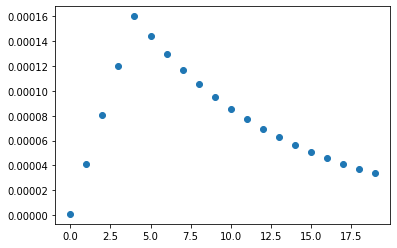

In [ ]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * config.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

## Train

In [ ]:
TRAINING_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS!=config.FOLD_TO_RUN]
VALIDATION_FILENAMES = [x for i,x in enumerate(train_files) if i%config.FOLDS==config.FOLD_TO_RUN]
print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))

8 2 40827 10206


In [ ]:
if config.DEBUG:
    TRAINING_FILENAMES = [TRAINING_FILENAMES[0]]
    VALIDATION_FILENAMES = [VALIDATION_FILENAMES[0]]
    print(len(TRAINING_FILENAMES),len(VALIDATION_FILENAMES),count_data_items(TRAINING_FILENAMES),count_data_items(VALIDATION_FILENAMES))
    test_files = [test_files[0]]

In [ ]:
seed_everything(config.SEED)
VERBOSE = 1
train_dataset = get_training_dataset(TRAINING_FILENAMES)
val_dataset = get_val_dataset(VALIDATION_FILENAMES)
STEPS_PER_EPOCH = count_data_items(TRAINING_FILENAMES) // config.BATCH_SIZE
# TEST_STEPS = -(-count_data_items(test_files) // BATCH_SIZE)             # The "-(-//)" trick rounds up instead of down :-)

train_logger = tf.keras.callbacks.CSVLogger(config.save_dir+'/training-log-fold-%i.h5.csv'%config.FOLD_TO_RUN)
# SAVE BEST MODEL EACH FOLD        
sv_loss = tf.keras.callbacks.ModelCheckpoint(
    config.save_dir+f"/{config.MODEL_NAME}_loss.h5", monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True, mode='min', save_freq='epoch')
# BUILD MODEL
K.clear_session()
model,embed_model = get_model()
snap = Snapshot(fold=config.FOLD_TO_RUN,snapshot_epochs=[5,8])
model.summary()

if config.RESUME:
    model.load_weights(config.resume_model_wts)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inp1 (InputLayer)              [(None, 896, 896, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 448, 448, 40  1080        ['inp1[0][0]']                   
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 448, 448, 40  160         ['stem_conv[0][0]']              
                                )                                                             

In [ ]:
print(f'#### Image Size {config.IMAGE_SIZE} with {config.MODEL_NAME} and batch_size {config.BATCH_SIZE}')

history = model.fit(train_dataset,
                validation_data = val_dataset,
                steps_per_epoch = STEPS_PER_EPOCH,
                epochs = config.EPOCHS,
                callbacks = [get_lr_callback(),train_logger,sv_loss],
                verbose = VERBOSE)

#### Image Size 896 with hybrid_swin_base_224 and batch_size 32
Epoch 1/20
1275/1275 [==============================] - 982s 656ms/step - loss: 18.6444 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.5612 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 1.0000e-06
Epoch 2/20
1275/1275 [==============================] - 559s 438ms/step - loss: 17.6404 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.1723 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 4.0750e-05
Epoch 3/20
1275/1275 [==============================] - 555s 436ms/step - loss: 17.1618 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.0079 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00 - lr: 8.0500e-

In [ ]:
print('Learning rate:', history.history['lr'])
n_col, n_row = 3, 1
fig, axes = plt.subplots(n_row, n_col, figsize=(9*n_col, 5*n_row))
for idx, (ax, name) in enumerate(zip(axes, ['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy'])):
    ax.title.set_text(name)
    ax.plot(history.history[name], label=name)
    ax.plot(history.history['val_'+name], label='val_'+name)
    ax.legend()

In [ ]:
model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_loss.h5")

## Evaluation

In [ ]:
def get_ids(filename):
    ds = get_test_dataset([filename],get_names=True).map(lambda image, image_name: image_name).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy().astype('U')
    return ids

def get_targets(filename):
    ds = get_eval_dataset([filename],get_targets=True).map(lambda image, target: target).unbatch()
    NUM_IMAGES = count_data_items([filename])
    ids = next(iter(ds.batch(NUM_IMAGES))).numpy()
    return ids

def get_embeddings(filename, steps=None):
    ds = get_test_dataset([filename],get_names=False)
    embeddings = embed_model.predict(ds, steps=steps, verbose=0)
    return embeddings

def get_predictions(test_df,threshold=0.2):
    predictions = {}
    for i,row in tqdm(test_df.iterrows()):
        if row.image in predictions:
            if len(predictions[row.image])==5:
                continue
            predictions[row.image].append(row.target)
        elif row.confidence>threshold:
            predictions[row.image] = [row.target,'new_individual']
        else:
            predictions[row.image] = ['new_individual',row.target]

    for x in tqdm(predictions):
        if len(predictions[x])<5:
            remaining = [y for y in sample_list if y not in predictions]
            predictions[x] = predictions[x]+remaining
            predictions[x] = predictions[x][:5]
        
    return predictions

def map_per_image(label, predictions):
    """Computes the precision score of one image.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """
    try:
        return 1 / (predictions[:5].index(label) + 1)
    except ValueError:
        return 0.0
    
f = open ('/content/individual_ids.json', "r")
target_encodings = json.loads(f.read())
target_encodings = {target_encodings[x]:x for x in target_encodings}
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [ ]:
TRAINING_FILENAMES

In [ ]:
train_targets = []
train_embeddings = []
for filename in tqdm(TRAINING_FILENAMES):
    fold_idx = int(re.search("train-([0-9])", filename)[1])
    fold_actual_size = 5104 if fold_idx <= 2 else 5103
    embeddings = get_embeddings(filename)[:fold_actual_size]
    targets = get_targets(filename)[:fold_actual_size]
    train_embeddings.append(embeddings)
    train_targets.append(targets)
train_embeddings = np.concatenate(train_embeddings)
train_targets = np.concatenate(train_targets)

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

In [ ]:
# test_ids = []
# test_nn_distances = []
# test_nn_idxs = []
# val_targets = []
# val_embeddings = []
# for filename in tqdm(VALIDATION_FILENAMES):
#     embeddings = get_embeddings(filename)
#     targets = get_targets(filename)
#     ids = get_ids(filename)
#     distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
#     test_ids.append(ids)
#     test_nn_idxs.append(idxs)
#     test_nn_distances.append(distances)
#     val_embeddings.append(embeddings)
#     val_targets.append(targets)
# test_nn_distances = np.concatenate(test_nn_distances)
# test_nn_idxs = np.concatenate(test_nn_idxs)
# test_ids = np.concatenate(test_ids)
# val_embeddings = np.concatenate(val_embeddings)
# val_targets = np.concatenate(val_targets)

val_ids = []
val_nn_distances = []
val_nn_idxs = []
val_targets = []
val_embeddings = []
for filename in tqdm(VALIDATION_FILENAMES):
    fold_idx = int(re.search("train-([0-9])", filename)[1])
    fold_actual_size = 5104 if fold_idx <= 2 else 5103
    embeddings = get_embeddings(filename)[:fold_actual_size]
    targets = get_targets(filename)[:fold_actual_size]
    ids = get_ids(filename)[:fold_actual_size]
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    val_ids.append(ids)
    val_nn_idxs.append(idxs)
    val_nn_distances.append(distances)
    val_embeddings.append(embeddings)
    val_targets.append(targets)
val_nn_distances = np.concatenate(val_nn_distances)
val_nn_idxs = np.concatenate(val_nn_idxs)
val_ids = np.concatenate(val_ids)
val_embeddings = np.concatenate(val_embeddings)
val_targets = np.concatenate(val_targets)

In [ ]:
# allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
# val_targets_df = pd.DataFrame(np.stack([test_ids,val_targets],axis=1),columns=['image','target'])
# val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
# val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
# val_targets_df.target.value_counts()

allowed_targets = set([target_encodings[x] for x in np.unique(train_targets)])
val_targets_df = pd.DataFrame(np.stack([val_ids,val_targets],axis=1),columns=['image','target'])
val_targets_df['target'] = val_targets_df['target'].astype(int).map(target_encodings)
val_targets_df.loc[~val_targets_df.target.isin(allowed_targets),'target'] = 'new_individual'
val_targets_df.target.value_counts()

In [ ]:
# test_df = []
# for i in tqdm(range(len(test_ids))):
#     id_ = test_ids[i]
#     targets = train_targets[test_nn_idxs[i]]
#     distances = test_nn_distances[i]
#     subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
#     subset_preds['image'] = id_
#     test_df.append(subset_preds)
# test_df = pd.concat(test_df).reset_index(drop=True)
# test_df['confidence'] = 1-test_df['distances']
# test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
# test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
# test_df['target'] = test_df['target'].map(target_encodings)
# test_df.to_csv('val_neighbors.csv')
# test_df.image.value_counts().value_counts()

val_df = []
for i in tqdm(range(len(val_ids))):
    id_ = val_ids[i]
    targets = train_targets[val_nn_idxs[i]]
    distances = val_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    val_df.append(subset_preds)
val_df = pd.concat(val_df).reset_index(drop=True)
val_df['confidence'] = 1-val_df['distances']
val_df = val_df.groupby(['image','target']).confidence.max().reset_index()
val_df = val_df.sort_values('confidence',ascending=False).reset_index(drop=True)
val_df['target'] = val_df['target'].map(target_encodings)
val_df.to_csv('val_neighbors.csv')
val_df.image.value_counts().value_counts()

In [ ]:
# ## Compute CV
# best_th = 0
# best_cv = 0
# for th in [0.1*x for x in range(11)]:
#     all_preds = get_predictions(test_df,threshold=th)
#     cv = 0
#     for i,row in val_targets_df.iterrows():
#         target = row.target
#         preds = all_preds[row.image]
#         val_targets_df.loc[i,th] = map_per_image(target,preds)
#     cv = val_targets_df[th].mean()
#     print(f"CV at threshold {th}: {cv}")
#     if cv>best_cv:
#         best_th = th
#         best_cv = cv

## Compute CV
best_th = 0
best_cv = 0
for th in [0.1*x for x in range(11)]:
    all_preds = get_predictions(val_df,threshold=th)
    cv = 0
    for i,row in val_targets_df.iterrows():
        target = row.target
        preds = all_preds[row.image]
        val_targets_df.loc[i,th] = map_per_image(target,preds)
    cv = val_targets_df[th].mean()
    print(f"CV at threshold {th}: {cv}")
    if cv>best_cv:
        best_th = th
        best_cv = cv

In [ ]:
print("Best threshold",best_th)
print("Best cv",best_cv)
val_targets_df.describe()

In [ ]:
## Adjustment: Since Public lb has nearly 10% 'new_individual' (Be Careful for private LB)
val_targets_df['is_new_individual'] = val_targets_df.target=='new_individual'
print(val_targets_df.is_new_individual.value_counts().to_dict())
val_scores = val_targets_df.groupby('is_new_individual').mean().T
val_scores['adjusted_cv'] = val_scores[True]*0.1+val_scores[False]*0.9
best_threshold_adjusted = val_scores['adjusted_cv'].idxmax()
print("best_threshold",best_threshold_adjusted)
val_scores

## Inference

In [ ]:
train_embeddings = np.concatenate([train_embeddings,val_embeddings])
train_targets = np.concatenate([train_targets,val_targets])
print(train_embeddings.shape,train_targets.shape)

In [ ]:
from sklearn.neighbors import NearestNeighbors
neigh = NearestNeighbors(n_neighbors=config.KNN,metric='cosine')
neigh.fit(train_embeddings)

In [ ]:
test_ids = []
test_nn_distances = []
test_nn_idxs = []
for filename in tqdm(test_files):
    fold_idx = int(re.search("test-([0-9])", filename)[1])
    fold_actual_size = 2796 if fold_idx <= 5 else 2795
    embeddings = get_embeddings(filename)[:fold_actual_size]
    ids = get_ids(filename)[:fold_actual_size]
    distances,idxs = neigh.kneighbors(embeddings, config.KNN, return_distance=True)
    test_ids.append(ids)
    test_nn_idxs.append(idxs)
    test_nn_distances.append(distances)
test_nn_distances = np.concatenate(test_nn_distances)
test_nn_idxs = np.concatenate(test_nn_idxs)
test_ids = np.concatenate(test_ids)

In [ ]:
# ds = get_test_dataset(test_files[0])

# # for (sample,label) in ds:
# #     img = sample['inp1']
# #     plt.figure(figsize=(25,int(25*row/col)))
# #     for j in range(row*col):
# #         plt.subplot(row,col,j+1)
# #         plt.title(label[j].numpy())
# #         plt.axis('off')
# #         plt.imshow(img[j,])
# #     plt.show()
# #     break
# # print(img.shape)

In [ ]:
sample_submission = pd.read_csv('/content/sample_submission.csv',index_col='image')
print(len(test_ids),len(sample_submission))
test_df = []
for i in tqdm(range(len(test_ids))):
    id_ = test_ids[i]
    targets = train_targets[test_nn_idxs[i]]
    distances = test_nn_distances[i]
    subset_preds = pd.DataFrame(np.stack([targets,distances],axis=1),columns=['target','distances'])
    subset_preds['image'] = id_
    test_df.append(subset_preds)
test_df = pd.concat(test_df).reset_index(drop=True)
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df['target'] = test_df['target'].map(target_encodings)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

In [ ]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']

In [ ]:
predictions = {}
for i,row in tqdm(test_df.iterrows()):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence>best_threshold_adjusted:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]
        
for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()